# 万物分割 Segment Anything Model (SAM)
Research by Meta AI

https://segment-anything.com/

https://github.com/facebookresearch/segment-anything


In [2]:
!git clone https://github.com/jumbojing/segment-anything

!pip install git+https://github.com/facebookresearch/segment-anything.git

import numpy as np 
import pandas as pd 
import os
from matplotlib import pyplot as plt
import torch
import cv2
import SimpleITK as sitk

!pip install supervision

import supervision as sv

%cd /kaggle/working/segment-anything/segment_anything

import skLogic as sk

Cloning into 'segment-anything'...
remote: Enumerating objects: 316, done.
remote: Total 316 (delta 0), reused 0 (delta 0), pack-reused 316
Receiving objects: 100% (316/316), 41.84 MiB | 9.18 MiB/s, done.
Resolving deltas: 100% (189/189), done.
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2q4ctq1d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2q4ctq1d
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36621 sha256=f9bfa88b302f66942622c12b656eb632bd0f2f43eff3de16558173c3e1cdb8d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-nojtkpt6/wheels/6e/b2/38/082465c177a067501384fd15cb18be1128372ef60f27a1c426
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━

## 材

- 尾s未3C

In [3]:
nMks = sk.readImgSk(f'/kaggle/input/tl768cts/verse768_CT-ax_seg.nii/verse768_CT-ax_seg.nii', img3C=False)

ndImgs = sk.readImgSk(f'/kaggle/input/verse768ct-nd/verse768_CT-ax.nrrd', img3C=False)

### 裁并对齐

In [4]:

def getCBx(img, thr=0, crop=False, pad=0): # pad是为了扩大bbox的范围
    """获取2D和3D图像的bbox, 返回xyxy或xyzxyz"""
    if isinstance(img, np.ndarray):
        img = sitk.GetImageFromArray(img)
    img = img > thr
    if isinstance(img,bool):
        return False
    d = img.GetDimension()
    ls = sitk.LabelShapeStatisticsImageFilter()
    ls.Execute(sitk.Cast(img, sitk.sitkUInt8))
    bb = np.array(ls.GetBoundingBox(1))
    ini, size = bb[:d], bb[d:]
    fin = ini + size
    ini -= pad
    fin += pad
    image_size = np.array(img.GetSize())
    ini[ini < 0] = 0 # 防止ini小于0
    for i in range(d):
        fin[i] = min(fin[i], image_size[i]) # 防止fin超出图像的范围
    size = fin - ini
    if crop:
        if d == 2:
            return img[ini[0]:fin[0], ini[1]:fin[1]]
        else:
            return img[ini[0]:fin[0], ini[1]:fin[1], ini[2]:fin[2]]
    else:
        return np.array(ini.tolist() + fin.tolist())

In [5]:
cMks = getCBx(nMks,crop=True)

In [6]:
sk.skShow(cMks)

size: (125, 124, 233)


interactive(children=(IntSlider(value=116, description='axe', max=232), Output()), _dom_classes=('widget-inter…

In [8]:
xyzArr = getCBx(nMks)

cdImgs = ndImgs[xyzArr[0]:xyzArr[3], xyzArr[1]:xyzArr[4], xyzArr[2]:xyzArr[5]]


nMkss = nMks[:,:,::-1]
cdImgss = cdImgs[:,:,::-1]

In [12]:
sk.skShow(cdImgss[:,:,85:145])

size: (125, 124, 60)


interactive(children=(IntSlider(value=29, description='axe', max=59), Output()), _dom_classes=('widget-interac…

In [9]:
bBxyxy = {}
for k in range(85,145):
    bBxyxy[k] = getCBx(cMks[:,:,k])   

In [10]:
# ground_truth_masks = {}
# for k in bBxyxy.keys():
#   gt_grayscale = cv2.imread(f'ground-truth-pixel/ground-truth-pixel/{k}-px.png', cv2.IMREAD_GRAYSCALE)
#   ground_truth_masks[k] = (gt_grayscale == 0)
# 参见 https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [21]:
cMk = sk.readImgSk(img= cMks)
cdImg = sk.readImgSk(img = cdImgs )

In [18]:
sk.pk2file('cdImg.pickle', cdImg)


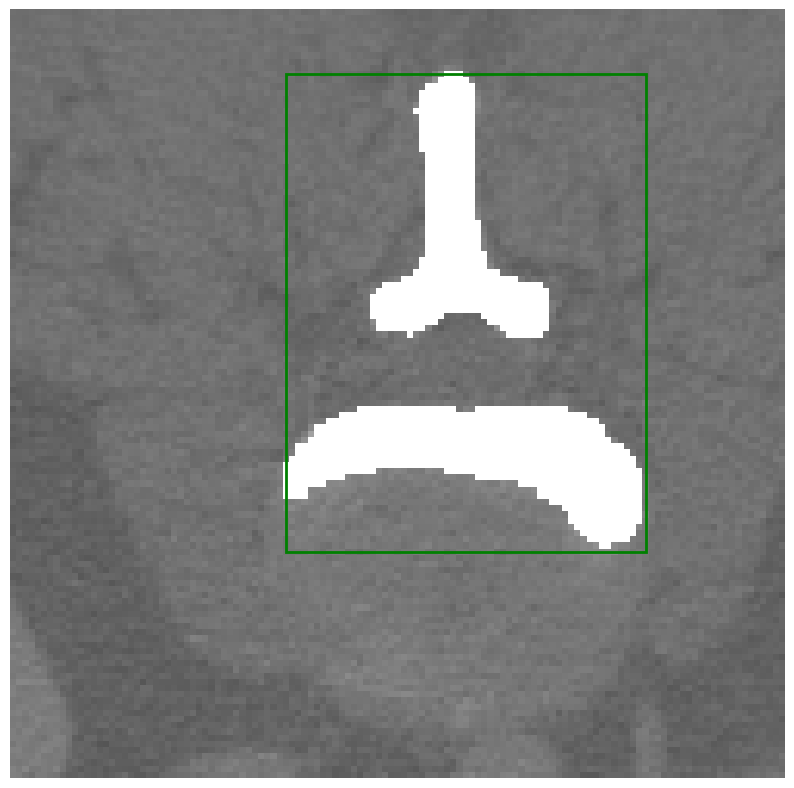

In [14]:
# name = 'stampDS-00004'
# image = cv2.imread(f'scans/scans/{name}.png')

plt.figure(figsize=(10,10))
plt.imshow(cdImg[100])
show_box(bBxyxy[100], plt.gca())
show_mask(cMk[100,:,:,0], plt.gca())
plt.axis('off')
plt.show()

In [17]:
#设置优化器，精调超参数, 以提高性能
lr = 1e-4 # 学习率
wd = 0 # 权重衰减
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd) # 优化器, 仅优化mask_decoder, 以提高性能

loss_fn = torch.nn.MSELoss() # 损失函数
# loss_fn = torch.nn.BCELoss()
keys = list(bBxyxy.keys()) # 所有的键b

In [15]:
model_type = 'vit_b'
checkpoint = '/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth'
device = 'cuda:0'

In [16]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

In [ ]:
tfmDic = defaultdict(dict)
for k in bbox_coords.keys():
  image = cv2.imread(f'scans/scans/{k}.png')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
  tfm = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = tfm.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  tfmed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
  
  input_image = sam_model.preprocess(tfmed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(tfmed_image.shape[-2:])

  tfmDic[k]['image'] = input_image
  tfmDic[k]['input_size'] = input_size
  tfmDic[k]['original_image_size'] = original_image_size

In [23]:


# 格式化图
from collections import defaultdict

import torch

from segment_anything.utils.tfms import ResizeLongestSide

tfmDic = defaultdict(dict)
# for k in range(60,120):
for k in bBxyxy.keys():
    
    img = cdImg[k]
    tfm = ResizeLongestSide(sam_model.image_encoder.img_size) # 转换图像大小
    iptImg = tfm.apply_image(img)
    iptImgTc = torch.as_tensor(iptImg, device=device) # 转换为张量
    tfmImg = iptImgTc.permute(2, 0, 1).contiguous()[None, :, :, :] # 转换为模型的输入格式

    iptImg = sam_model.preprocess(tfmImg) # 预处理图像
    original_image_size = img.shape[:2] # 原始图像大小
    input_size = tuple(tfmImg.shape[-2:]) # 输入图像大小

    tfmDic[k]['image'] = iptImg # 图像归典
    tfmDic[k]['input_size'] = input_size # 大小归典
    tfmDic[k]['original_image_size'] = original_image_size # 原始图像大小归典

In [28]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 100 # 迭次
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  # 仅炼前20个
  for k in keys:
    input_image = tfmDic[k]['image'].to(device) # 将图像转换为设备
    input_size = tfmDic[k]['input_size'] # 输入大小
    original_image_size = tfmDic[k]['original_image_size'] # 原始图像大小
    
    # 嵌图, 不算梯度
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image) # 嵌图
      
      prompt_box = bBxyxy[k] # 框
      box = tfm.apply_boxes(prompt_box, original_image_size) # 转换
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device) # 转张量
      box_torch = box_torch[None, :] # 增维
      
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder( # 提示框嵌图
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder( # 罩解码
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device) # 罩的后处理
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0)) # 二分

    gt_mask_resized = torch.from_numpy(np.resize(cMk[k], 
                                                (1, 1, cMk[k].shape[0], cMk[k].shape[1]))
                                       ).to(device) # 底罩
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32) # 二分
    
    loss = loss_fn(binary_mask, gt_binary_mask) # 损失
    optimizer.zero_grad() # 梯度归零
    loss.backward() # 反向传播, 是指向优化器
    optimizer.step() # 优化, 更新参数包括mask_decoder的参数包括: image_encoder, prompt_encoder, mask_decoder
    epoch_losses.append(loss.item()) # 记录损失
  losses.append(epoch_losses) # 记录损失
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

EPOCH: 0
Mean loss: 0.9364677170912424
EPOCH: 1
Mean loss: 0.9366515864928563
EPOCH: 2
Mean loss: 0.9370128810405731
EPOCH: 3
Mean loss: 0.9370075047016144
EPOCH: 4
Mean loss: 0.9369870752096177
EPOCH: 5
Mean loss: 0.93700965543588
EPOCH: 6
Mean loss: 0.9370128810405731
EPOCH: 7
Mean loss: 0.9370128810405731
EPOCH: 8
Mean loss: 0.9370118051767349
EPOCH: 9
Mean loss: 0.9370204081137975
EPOCH: 10
Mean loss: 0.9370032042264939
EPOCH: 11
Mean loss: 0.9369902988274892
EPOCH: 12
Mean loss: 0.9369946012894312
EPOCH: 13
Mean loss: 0.93699997762839
EPOCH: 14
Mean loss: 0.93699997762839
EPOCH: 15
Mean loss: 0.93699997762839
EPOCH: 16
Mean loss: 0.9370021283626556
EPOCH: 17
Mean loss: 0.9368763208389282
EPOCH: 18
Mean loss: 0.9369214822848638
EPOCH: 19
Mean loss: 0.9368924498558044
EPOCH: 20
Mean loss: 0.93692793349425
EPOCH: 21
Mean loss: 0.9367214808861415
EPOCH: 22
Mean loss: 0.9368161042531331
EPOCH: 23
Mean loss: 0.9369021276632945
EPOCH: 24
Mean loss: 0.9370085795720419


KeyboardInterrupt: 

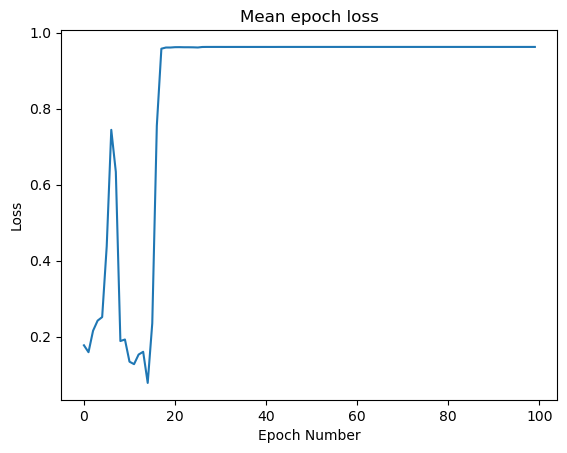

In [27]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [10]:
mks = []
for img in cImgs:
    mks.append(mask_generator.generate(img))

In [15]:
np.array(mks)[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 1468,
  'bbox': [119.0, 157.0, 51.0, 53.0],
  'predicted_iou': 0.9239425659179688,
  'point_coords': [[151.21875, 190.65625]],
  'stability_score': 0.9413702487945557,
  'crop_box': [89.0, 109.0, 181.0, 201.0]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False,  True,  True, ...,  True,  True, False],
         [False,  True,  True, ...,  True,  True, False],
         [False,  True,  True, ...,  True,  True, False]]),
  'area': 69589,
 

In [13]:
svData = sk.svAllSam(np.array(mks))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


TypeError: list indices must be integers or slices, not str

In [20]:
sk.pk2file(f'svData.pickle', mks)

In [19]:
cd ..

/kaggle/working


In [1]:
img = sk.svShow(cImgs[5],mks[0])

NameError: name 'sk' is not defined

In [19]:
np.array(mks).shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(22,)

In [25]:
img.shape

(310, 270, 3)

In [26]:
sk.skShow(img[:,:,0])

size: (270, 310, 1)


interactive(children=(IntSlider(value=0, description='axe', max=0), Output()), _dom_classes=('widget-interact'…

In [81]:
%matplotlib inline
sv.plot_image(detections, (16, 16))

AttributeError: 'Detections' object has no attribute 'ndim'

<Figure size 1600x1600 with 0 Axes>

In [80]:
detections

Detections(xyxy=array([[175., 119., 317., 384.],
       [  0.,   0.,  32., 511.],
       [ 64., 377., 178., 511.],
       [493.,   0., 511., 495.],
       [164.,  87., 323., 195.],
       [357., 412., 426., 504.],
       [280.,  39., 318.,  86.],
       [357., 433., 381., 504.],
       [175., 473., 215., 511.],
       [394., 306., 414., 329.],
       [ 53., 494.,  65., 511.]]), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True, 

返回: 所有物体的罩的字典的列表包括:
* `segmentation` : 罩
* `area` :  面积(以像素为单位)
* `bbox` :  覆框(XYWH)
* `predicted_iou` : 和模型本身的交并比(质量预测)
* `point_coords` :  采点坐标
* `stability_score` :  稳定分
* `crop_box` : 裁框(全图XYWH)

In [44]:
masks[3]


{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 1415,
 'bbox': [280.0, 39.0, 38.0, 47.0],
 'predicted_iou': 0.9696633815765381,
 'point_coords': [[312.0, 56.0]],
 'stability_score': 0.9679219126701355,
 'crop_box': [0, 0, 512, 512]}

    def __init__(
        self,
        model: Sam,
        points_per_side: Optional[int] = 32,
        points_per_batch: int = 64,
        pred_iou_thresh: float = 0.88,
        stability_score_thresh: float = 0.95,
        stability_score_offset: float = 1.0,
        box_nms_thresh: float = 0.7,
        crop_n_layers: int = 0,
        crop_nms_thresh: float = 0.7,
        crop_overlap_ratio: float = 512 / 1500,
        crop_n_points_downscale_factor: int = 1,
        point_grids: Optional[List[np.ndarray]] = None,
        min_mask_region_area: int = 0,
        output_mode: str = "binary_mask",
    ) -> None:
            模型（Sam）：用于掩模预测的Sam模型。
            points_per_side（int或None）：沿图像一侧采样的点数。总点数为points_per_side**2。如果“无”，则“point_grids”必须提供显式点采样。 `边点数`
            points_per_batch（int）：设置模型同时运行的点数。更高的数字可能更快，但使用更多的GPU内存。 `批点数`
            pred_iou_thresh（float）：[0,1]中的滤波阈值，使用模型的预测掩码质量。 `交并比阈值`
            stability_score_thresh（float）：[0,1]中的滤波阈值，使用掩码在用于对模型的掩码预测进行二值化的截止值变化下的稳定性。
            stability_score_offset（float）：计算稳定性分数时偏移截止值的量。
            box_nms_thresh（float）：非最大抑制用于过滤重复掩码的box-IoU截止。
            crops_n_layers（int）：如果>0，将在图像的裁剪上再次运行掩码预测。设置要运行的层数，其中每层具有2*i_layer数量的图像裁剪。
            crops_nms_thresh（float）：非最大抑制用于过滤不同作物之间的重复掩码的框IoU截止。
            crop_overlap_ratio（float）：设置作物重叠的程度。
            在第一个裁剪层中，裁剪将重叠图像长度的这一部分。后期作物较多的层缩小了这种重叠。
            crop_n_points_downscale_factor（int）：在层n中每侧采样的点数由crop_n_points s_downsale_factor**n按比例缩小。
            point_grids（list（np.ndarray）或None）：用于采样的点的显式网格上的列表，标准化为[0,1]。列表中的第n个栅格用于第n个裁剪层。与points_per_side独占。
            min_mask_region_area（int）：如果>0，将应用后处理来移除面积小于min_mask-region_a雷亚的掩模中断开连接的区域和孔。需要opencv。
            output_mode（str）：在中返回表单掩码。可以是“binary_mask”、“uncompressed_rle”或“coco_rle”“coco_rle”需要pycocotools。
            对于大分辨率，“binary_mask”可能会消耗大量内存。

In [50]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # 边点数
    pred_iou_thresh=0.86, # 交并比率
    stability_score_thresh=0.92, # 稳分率
    crop_n_layers=1, # 
    crop_n_points_downscale_factor=2, # 
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

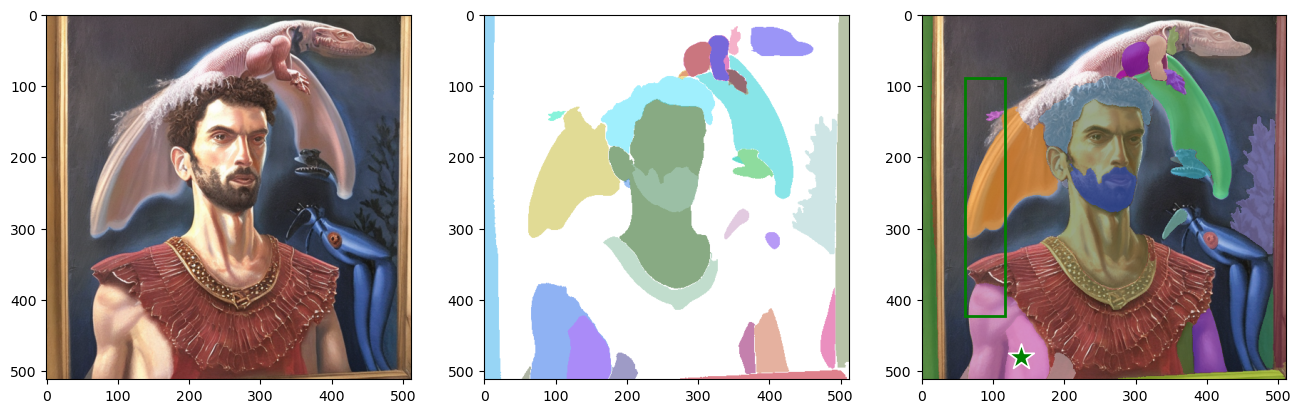

In [52]:
_, axes = plt.subplots(1,3, figsize=(16,16))
axes[0].imshow(image_array)
show_anns(masks2, axes[1])
show_box(masks2[3]['bbox'],axes[2])
show_points(np.array(masks2[3]['point_coords']),np.array([1]),axes[2])
# show_box(masks[1]['crop_box'],axes[1])
axes[2].imshow(image_array)
show_anns(masks2, axes[2])

In [90]:
detections

Detections(xyxy=array([[175., 119., 317., 384.],
       [  0.,   0.,  32., 511.],
       [ 64., 377., 178., 511.],
       [493.,   0., 511., 495.],
       [164.,  87., 323., 195.],
       [357., 412., 426., 504.],
       [280.,  39., 318.,  86.],
       [357., 433., 381., 504.],
       [175., 473., 215., 511.],
       [394., 306., 414., 329.],
       [ 53., 494.,  65., 511.]]), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True, 

👆🏻的结果似乎不理想, 分割不够全, 比如铠甲没分出来, 而且标注的框和点也是莫名奇妙的...

#### 精调之一: 显示精调

- 应用`supervison`

In [15]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

0.6.0


In [56]:
def svAllSam(sam_result):
    
    sorted_generated_masks = sorted(
        sam_result, key=lambda x: x["area"], reverse=True
    )

    xywh = np.array([mask["bbox"] for mask in sorted_generated_masks])
    mask = np.array([mask["segmentation"] for mask in sorted_generated_masks])
    confidence = np.array([mask["predicted_iou"] for mask in sorted_generated_masks])
    class_id = np.arange(len(sorted_generated_masks))
    return sv.Detections(xyxy=xywh_to_xyxy(boxes_xywh=xywh),
                         mask=mask,
                         confidence=np.array(confidence),
                         class_id=class_id
                        )

def xywh_to_xyxy(boxes_xywh: np.ndarray) -> np.ndarray:
    xyxy = boxes_xywh.copy()
    xyxy[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2]
    xyxy[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3]
    return xyxy
def svMks(img, anns = None, lbs='', mask=True, svBx=True, show=False):
    dets = svAllSam(anns)
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    if dets.class_id is None:
        dets.class_id = np.arange(len(dets))    
    labels = []
    for _, _, confidence, class_id,_ in dets:
        label = f'{lbs}_{class_id}: {confidence:0.2f}'
        labels.append(label)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if lbs != '':
        dets.lable=lbs    
    if mask:
        annotated_image = mask_annotator.annotate(scene=img, detections=dets)
        if svBx:
            annotated_image = box_annotator.annotate(scene=annotated_image, detections=dets, labels=labels)
    else:
        if svBx:
            annotated_image = box_annotator.annotate(scene=img, detections=dets, labels=labels)
        else:
            print('啥都不要, 所以啥都没有...')
            return  dets     
    if show:
        %matplotlib inline
        sv.plot_image(annotated_image, (16, 16))
    else:
        return annotated_image, dets

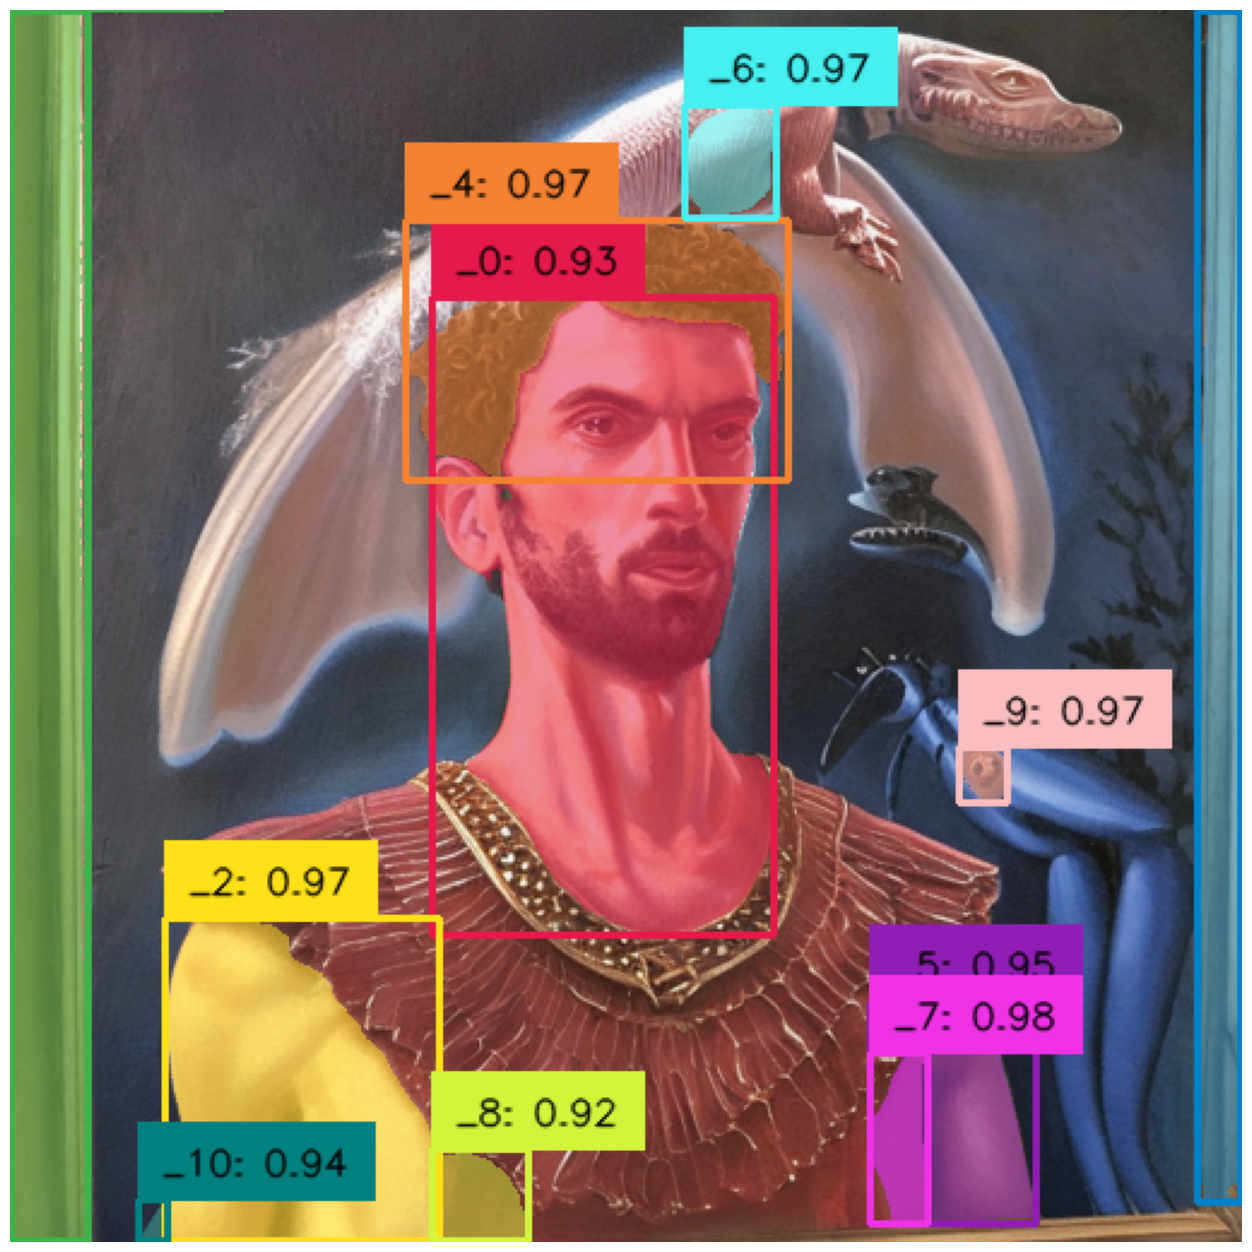

In [48]:
svMks(image_array,masks,show=True,mask=True)

In [12]:
del(mask_generator)

# 万分之提示生罩

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

In [58]:
from segment_anything import sam_model_registry, SamPredictor

predictor = SamPredictor(sam)

# 万分的选择


## 点选

NameError: name 'show_points' is not defined

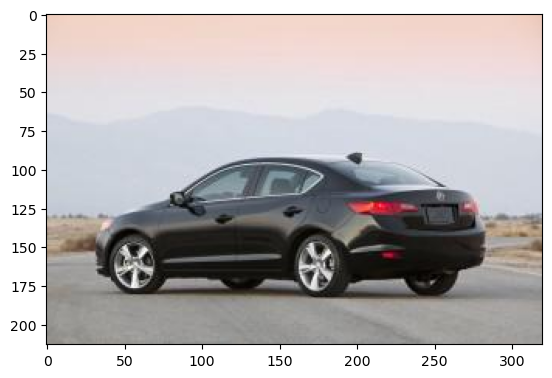

In [59]:
image_path = '/kaggle/input/the-car-connection-picture-dataset/Acura_ILX_2014_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_Klc.jpg'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
predictor.set_image(image_array)

input_point = np.array([[120, 135]])
input_label = np.array([1])

plt.imshow(image_array)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  



masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)): # 每次产生仨罩: 安装自评分排序
#     plt.figure(figsize=(10,10))
    plt.imshow(image_array)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.show()  
  

<!-- ## Specifying a specific object with additional points (include and exclude) -->
## 二分点选(含和不含)

In [57]:
image_path = '/kaggle/input/stable-diffusion-image-to-prompts/images/c98f79f71.png'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
predictor.set_image(image_array)

input_point = np.array([[300, 50], [185, 100], [250, 200], [400, 50]])
input_label = np.array([1, 1, 0, 1])

plt.imshow(image_array)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  



masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
    plt.imshow(image_array)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.show()  

NameError: name 'predictor' is not defined

In [ ]:
image_path = '/kaggle/input/happy-whale-and-dolphin/train_images/00177f3c614d1e.jpg'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
predictor.set_image(image_array)

input_point = np.array([[1400, 1600], [2500, 500]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # 选最高分
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.imshow(image_array)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.show()   

## 框选


In [ ]:
input_box = np.array([600, 1100, 2100, 1800]) # xyXY格式
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)
plt.imshow(image_array)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.show()

Follow this notebook for additional prompting options:

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb